In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import binarize
%matplotlib inline

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [3]:
### Reading User Log
user_log = pd.read_csv('user_logs_v2.csv')
user_log.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [4]:
### Reading Transaction Data
transaction = pd.read_csv('transactions_v2.csv')
transaction.head(3)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0


In [5]:
### Reading Training data
train_data = pd.read_csv('train_v2.csv')
train_data.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [51]:
### Reading sample submission data
Sample_Submission_v2 = pd.read_csv('sample_submission_v2.csv')
Sample_Submission_v2.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0


In [7]:
### Grouping on MSNO
t = transaction.groupby('msno').agg({'payment_method_id' : 'count',
                       'payment_plan_days' : 'sum',
                       'actual_amount_paid' : 'sum',
                       'is_auto_renew' : 'max',
                       'is_cancel' : 'max'
                      })
t['msno'] = t.index

In [8]:
transaction1 = transaction.copy()

In [9]:
### Creating trans_dt and expiry_dt field
transaction1['transaction_date'] = transaction1.transaction_date.astype(str)
transaction1['membership_expire_date'] = transaction1.membership_expire_date.astype(str)

transaction1['trans_dt'] = transaction1.transaction_date.str[0:4] + "-" + transaction1.transaction_date.str[4:6] + "-" + transaction1.transaction_date.str[6:8]
transaction1['expiry_dt'] = transaction1.membership_expire_date.str[0:4] + "-" + transaction1.membership_expire_date.str[4:6] + "-" + transaction1.membership_expire_date.str[6:8]

transaction1.trans_dt = pd.to_datetime(transaction1.trans_dt, format= '%Y-%m-%d')
transaction1.expiry_dt = pd.to_datetime(transaction1.expiry_dt, format= '%Y-%m-%d')

transaction1.head(3)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,trans_dt,expiry_dt
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0,2017-01-31,2017-05-04
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0,2015-08-09,2019-04-12
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0,2017-03-03,2017-04-22


In [10]:
### Finding Last Transdate
t1 = transaction1.groupby('msno').agg({'trans_dt': max,
                                       'is_cancel': max})
t1['msno'] = t1.index
t1.head(3)

,trans_dt,is_cancel,msno
msno,,,
+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,2016-10-23,0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-03-15,0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2017-03-31,0,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=


In [11]:
### Merging data to get Last transation details
t2 = pd.merge(t1, transaction1, how = 'left', on = ('msno','trans_dt', 'is_cancel'))

In [12]:
transaction1[transaction1.msno == 'QMnMEY866c5zTCWaNQTdBZWp96WCwuVKr11V32d8TDw='].to_csv('output.csv', sep =',')

In [13]:
### Dropping columns 'transaction_date', 'membership_expire_date' and removing duplicate columns
t3 = t2.drop(['transaction_date', 'membership_expire_date'], axis = 1).drop_duplicates(keep = 'first')
t3.msno.value_counts().head(3)

SNlFRAsmUqnXKPofSXA8WYUc5DtmLcUMy4pXSJ3Ohz0=    131
OGKDrZQDB3yewZhoSd5qqvmG5A1GcNTYMexO95NlH+g=    118
vf6eQrnFfiS9o1kB/gRUJ4iTUixS9tHNKizqQ/1vLDI=    117
Name: msno, dtype: int64

In [14]:
### Finding expiry date to get expiry date transation detail
t4 = t3.groupby(['msno']).agg({'expiry_dt' : 'max'})
t4['msno'] = t4.index

In [15]:
### Merging on Max expiry_dt
t5 = pd.merge(t3, t4, on = ('msno', 'expiry_dt'), how = 'inner').drop_duplicates(keep ='first')
t5.head(3)

,trans_dt,is_cancel,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,expiry_dt
0,2016-10-23,0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,22.0,395.0,1599.0,1599.0,0.0,2018-02-06
1,2017-03-15,0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41.0,30.0,99.0,99.0,1.0,2017-04-15
2,2017-03-31,0,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39.0,30.0,149.0,149.0,1.0,2017-05-19


In [16]:
### Dropping column 'plan_list_price', 'actual_amount_paid' and removing duplicates
t_last = t5.drop(['plan_list_price', 'actual_amount_paid'], axis = 1).drop_duplicates(keep = 'first')
print(t_last.msno.value_counts().head(5))
print('\nTotal Members : ' ,t_last.msno.value_counts().shape)
print('\n',t_last.head(5))

zHMgxEojpM02p2xIwlwaRVseaYTRGPMjorCeG5sU9n8=    1
qH9N8rBDPE9z3/qdNe/yQ7RSyF0Qyrouut6t5Vo1t4U=    1
KNdBJzGSyU/vW/OVclaeNQXgApsyeAI3BLqIOorV+UM=    1
Q8Bze+aPMbZLZuOD5sRGRg8y5M9SOoMn+cI9X5q04Ko=    1
S3uaFlzTBolsIC7HZsq9TPi6RtLsV8UhQpsZLeHd0uY=    1
Name: msno, dtype: int64

Total Members :  (1197050,)

     trans_dt  is_cancel                                          msno  \
0 2016-10-23          0  +++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=   
1 2017-03-15          0  +++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=   
2 2017-03-31          0  +++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=   
3 2017-03-26          0  +++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=   
4 2017-03-15          0  ++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=   

   payment_method_id  payment_plan_days  is_auto_renew  expiry_dt  
0               22.0              395.0            0.0 2018-02-06  
1               41.0               30.0            1.0 2017-04-15  
2               39.0               30.0            

In [17]:
### Renaming columns of Last Transation table
t_last.rename(columns= {'payment_method_id' : 'Last_payment_method_id',
                        'payment_plan_days' : 'Last_payment_plan_days',
                        'is_cancel' : 'Last_is_cancel',
                        'is_auto_renew' : 'Last_is_auto_renew'
                       }, inplace = True)

In [18]:
user_log.columns

Index(['msno', 'date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100',
       'num_unq', 'total_secs'],
      dtype='object')

In [19]:
### Aggregating User Log details
u1 = user_log.groupby('msno').agg({'num_25' : sum,
                              'num_50' : sum,
                              'num_75' : sum,
                              'num_985' : sum,
                              'num_100' : sum,
                              'num_unq' : sum,
                              'total_secs' :sum})

In [20]:
print('total Records : ', u1.shape, '\n')
u1.head()
u1['msno'] = u1.index

total Records :  (1103894, 7) 



In [21]:
### Merging Last Transaction with total transaction detail
Total_with_Last = pd.merge(t, t_last.drop(['trans_dt', 'expiry_dt'], axis =1), on = 'msno', how = 'inner')
Total_with_Last.head()

,actual_amount_paid,is_cancel,is_auto_renew,payment_plan_days,payment_method_id,msno,Last_is_cancel,Last_payment_method_id,Last_payment_plan_days,Last_is_auto_renew
0,1599,0,0,395,1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,0,22.0,395.0,0.0
1,99,0,1,30,1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41.0,30.0,1.0
2,298,0,1,60,2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0,39.0,30.0,1.0
3,149,0,1,30,1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0,41.0,30.0,1.0
4,149,0,1,30,1,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0,41.0,30.0,1.0


In [22]:
### Merging Total_with_Last with user log
Total_with_last_with_log = pd.merge(Total_with_Last, u1, on = 'msno', how = 'inner')
Total_with_last_with_log.head(5)

,actual_amount_paid,is_cancel,is_auto_renew,payment_plan_days,payment_method_id,msno,Last_is_cancel,Last_payment_method_id,Last_payment_plan_days,Last_is_auto_renew,num_50,num_unq,total_secs,num_100,num_75,num_985,num_25
0,1599,0,0,395,1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,0,22.0,395.0,0.0,11,530,117907.425,472,10,5,86
1,99,0,1,30,1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41.0,30.0,1.0,90,885,192527.892,589,75,144,191
2,298,0,1,60,2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0,39.0,30.0,1.0,12,468,115411.260,485,15,12,43
3,149,0,1,30,1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0,41.0,30.0,1.0,163,828,149896.558,436,100,64,207
4,149,0,1,30,1,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0,41.0,30.0,1.0,24,230,116433.247,479,39,35,105


In [23]:
### Dropping NA 
Total_with_last_with_log.dropna(inplace= True)

In [24]:
### Merging with churn
Final = pd.merge(Total_with_last_with_log, train_data, on = 'msno', how = 'inner')
Final.head(3)

,actual_amount_paid,is_cancel,is_auto_renew,payment_plan_days,payment_method_id,msno,Last_is_cancel,Last_payment_method_id,Last_payment_plan_days,Last_is_auto_renew,num_50,num_unq,total_secs,num_100,num_75,num_985,num_25,is_churn
0,99,0,1,30,1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41.0,30.0,1.0,90,885,192527.892,589,75,144,191,0
1,298,0,1,60,2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0,39.0,30.0,1.0,12,468,115411.260,485,15,12,43,0
2,149,0,1,30,1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0,41.0,30.0,1.0,163,828,149896.558,436,100,64,207,0


In [25]:
### train test split
x_train, x_test, y_train, y_test = train_test_split(Final.drop('is_churn', axis = 1), Final.is_churn, 
                                                    test_size=0.33, random_state=42)

In [26]:
print('x_train : ', x_train.shape, '\n')
print('x_test : ', x_test.shape, '\n')
print('y_train : ', y_train.shape, '\n')
print('y_test : ', y_test.shape, '\n')

x_train :  (482410, 17) 

x_test :  (237605, 17) 

y_train :  (482410,) 

y_test :  (237605,) 



In [27]:
rf = RandomForestClassifier()

In [28]:
rf.fit(x_train.drop('msno', axis =1), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

([<matplotlib.axis.XTick at 0x164ea4400>,
 <a list of 16 Text xticklabel objects>)

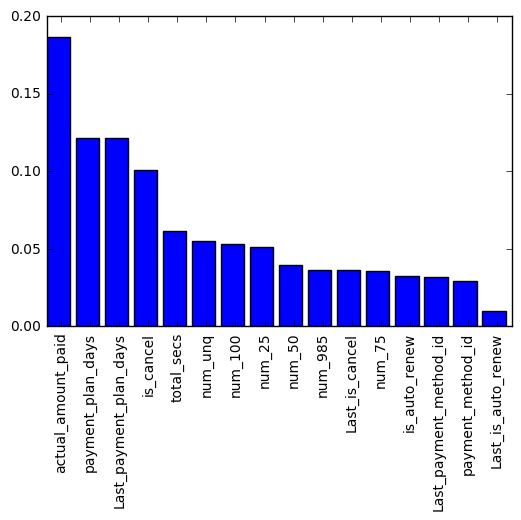

In [29]:
#### Finding Important Features
a = pd.DataFrame({'Column' : x_train.drop('msno', axis =1).columns,
             'Importance' : rf.feature_importances_})
a = a.sort_values('Importance', ascending= False)
a = a.reset_index(drop=True)
plt.bar(a.index, a.Importance)
plt.xticks(a.index+.5,a.Column, rotation = 90)

In [30]:
rf.score(x_train.drop('msno', axis =1), y_train)

0.99611119172488127

In [31]:
#### Confusion metrix
y_pred = rf.predict(x_train.drop('msno', axis =1))
confusion_matrix(y_train, y_pred)

array([[451580,     82],
       [  1794,  28954]])

In [32]:
#### Checking roc_auc_score
roc_auc_score(y_score=y_pred, y_true=y_train )

0.97073659504025667

In [33]:
#### Checking accuracy score on test data
y_test_pred = rf.predict(x_test.drop('msno', axis =1))
accuracy_score(y_pred=y_test_pred, y_true=y_test)

0.97457965951894954

In [34]:
#### cross_val for tuning n_estimators
m_estimate = np.arange(20,75,8)
m_result = []
for i in range(0,len(m_estimate)):
    rf1 = RandomForestClassifier(n_estimators = m_estimate[i])
    s1 = np.mean(cross_val_score(rf1, X=Final.drop(['is_churn','msno'], axis = 1), y=Final.is_churn, scoring='accuracy', cv = 4))
    m_result.append(s1)

In [36]:
m_result

[0.97521162672486039,
 0.9752894029517446,
 0.97548106599965489,
 0.9753935682603988,
 0.97551023203361997,
 0.97548801035922394,
 0.97554217588393988]

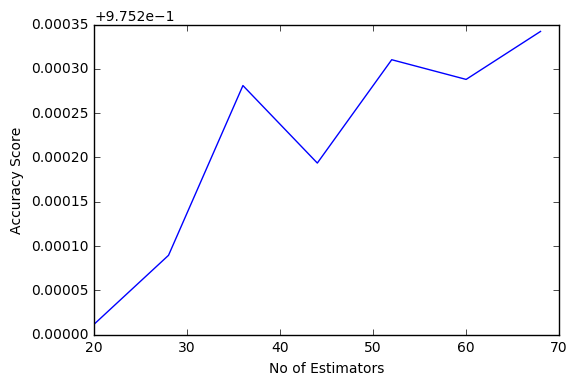

In [35]:
plt.plot(m_estimate, m_result)
plt.xlabel('No of Estimators')
plt.ylabel('Accuracy Score')

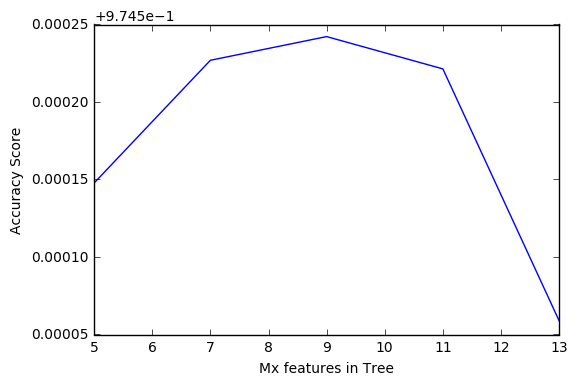

In [38]:
#### cross_val for tuning max_features
m_features = np.arange(5,15,2)
m_result1 = []
for i in range(0,len(m_features)):
    rf1 = RandomForestClassifier(max_features = m_features[i])
    s1 = np.mean(cross_val_score(rf1, X=Final.drop(['is_churn','msno'], axis = 1), y=Final.is_churn, scoring='accuracy', cv = 4))
    m_result1.append(s1)
plt.plot(m_features, m_result1)
plt.xlabel('Mx features in Tree')
plt.ylabel('Accuracy Score')

In [44]:
#### Ensemble Random Forest with multiple models of different random states for better accuracy
rf_final1 = RandomForestClassifier(n_estimators=52, max_features=9, random_state=123)
rf_final1.fit(X=Final.drop(['is_churn','msno'], axis = 1), y=Final.is_churn)

rf_final2 = RandomForestClassifier(n_estimators=52, max_features=9, random_state=145)
rf_final2.fit(X=Final.drop(['is_churn','msno'], axis = 1), y=Final.is_churn)

rf_final3 = RandomForestClassifier(n_estimators=52, max_features=9, random_state=117)
rf_final3.fit(X=Final.drop(['is_churn','msno'], axis = 1), y=Final.is_churn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=9, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=52, n_jobs=1,
            oob_score=False, random_state=117, verbose=0, warm_start=False)

In [85]:
#### Reading Final Submission file
Final_Submission = pd.read_csv('sample_submission_v2.csv')
Final_Submission.shape

(907471, 2)

In [96]:
#### Preparing Attributes for final submission
Total_Final = pd.merge(Total_with_Last, u1, on = 'msno', how = 'left')
Total_Final = Total_Final.fillna(0)

#### Merging Attribute data with Final_Submission
Final_Submission1 = pd.merge(Total_Final, Final_Submission, on = 'msno', how ='inner')
print(Final_Submission1.msno.value_counts().head(5))
print('\n', Final_Submission1.msno.value_counts().shape)

yar9OotTzPtAHZ3mBrN+TyFBqTAqGEpKd/VKMDsRa/o=    1
85fkh4wEXjUFWivh3YEWcL3Eu0PnkqAyv6j31zucrOQ=    1
YYLRopTimppJyvmwpwfaB4f3J0xSQJDsf5q0gbWqaNQ=    1
8GQEouIW0OdruSZQre2egB8gKUhe0KeNmVcLsFnh11s=    1
w6ifafhP6GI2qix+58weKkqY0BfjJuv32sHAAAXKaro=    1
Name: msno, dtype: int64

 (907470,)


In [98]:
#### Ensembling output of three random forest
p1 = .30*rf_final1.predict_proba(Final_Submission1.drop(['is_churn', 'msno'], axis = 1))
p2 = .35*rf_final2.predict_proba(Final_Submission1.drop(['is_churn', 'msno'], axis = 1))
p3 = .35*rf_final3.predict_proba(Final_Submission1.drop(['is_churn', 'msno'], axis = 1))

p_final = p1 + p2 + p3

In [110]:
#### Binarizing p_final with threshold of .5
output = binarize(p_final, threshold=0.5)

In [179]:
Final_Sub_v1 = pd.DataFrame({'msno' : Final_Submission1['msno'],
                                 'is_churn' : p_final[:,1]})

In [180]:
f2.head()

,is_churn,msno
0,1.0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=
1,1.0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=
2,1.0,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=
3,1.0,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=
4,1.0,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=


In [181]:
f2 = Final_Sub_v1.append(pd.DataFrame({'msno' : ['VJx7ZXB+BP/true7UpJTYyAsv7ItjWWaRrtY/Zg0+VE='],
                   'is_churn' : [1]}))
f2.shape

(907471, 2)

In [182]:
f2.to_csv('Final_Sub_v1.csv', sep = ',', index=False, header=True)

In [183]:
Final_Sub_v1.head()

,is_churn,msno
0,0.005769,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=
1,0.000000,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=
2,0.020192,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=
3,0.000000,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=
4,0.020192,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=
